# How to use the Multiparameter persistence Module Approximation library.
This notebook provides a detailed example using the main functions of this library.

## Setup

The easiest way to compile / install this python library is using pip :

In [1]:
 # ! pip install --user src/ 

In [2]:
import matplotlib.pyplot as plt		# Plot library of Python.
import gudhi as gd   				# TDA library. This will help us generate chain complexes with the simplextree structure.
import numpy as np   				# As math in python is broken we need numpy 
import mma 		 		 			# Our python library to approximate n-persistence modules.

## Synthetic example

In this case we will take a simple simplextree to create a circle, but in a "real usecase" you will want to take a simplextree generated via a dataset. 

In [3]:
simplextree = mma.SimplexTreeMulti()     # SimplexTree is the data structure of gudhi to hold filtered complexes
simplextree.insert([0,1,2])        # we add the triangle 0-1-2 to the complex.

True

In [4]:

#    0---2
#    |**/
#    |*/
#    |/
#    1

### Consider a bi-filtration ie. a list of filtrations of the simplices

A bi-filtration will define when a simplex will appear (in $\mathbb R^2$)

In general you can give as an input an `n`-filtration, but we will stick to `n=2` for the moment, to have access to the plot functions. <br>
We assign here a bifiltration value to each simplex. For the moment, the python interface only allows 1-critical filtrations.

In [5]:
#simplextree.assign_filtration(simplex, bifiltration value)
simplextree.assign_filtration([0], [0,0]) # The vertices appear at [0,0]
simplextree.assign_filtration([1], [0,0])
simplextree.assign_filtration([2], [0,0])
simplextree.assign_filtration([0,1], [1,2]) # The edges (and the cycle) appear at [1,2]
simplextree.assign_filtration([0,2], [1,2])
simplextree.assign_filtration([1,2], [1,2])
simplextree.assign_filtration([0,1,2], [3,3]) # The triangle appears at [3,3], and kills the cycle

Remark : This can be done in a faster way, e.g.,

In [6]:
simplextree = mma.SimplexTreeMulti()
simplextree.insert([0,1,2], [0,0])  
for s,f in simplextree.get_skeleton(1):
	simplextree.assign_filtration(s, [1,2])
simplextree.assign_filtration([0,1,2], [3,3])

### Compute `n`-module approximations

The simplextree defines a bifiltration, we now want to compute its homology. <br>
We use the `persistence` method. It takes the following optional parameters:
- `max_error` The precision w.r.t. the bottleneck distance, when the infered module is decomposable into intervals.
  - a smaller precision can increase the quality of the approximation,
  - a bigger precision reduces the compute time.
- `nlines:int` The (minimum) number of line to compute the approximation (computational bound). 
- `box` Used to compute module restricted to this box.
  - Format : [x,y], where x,y defines the rectangle {z : x ≤ z ≤ y}. 
- `threshold=False` If set to `True`,  intersects the summands with the box
- `verbose = False` : If set to `True`, the `C++` code will give some information about the computation.

In [7]:
approximation_parameters = {
    "nlines":10,
    "box": [[0,0], [4,4]],
    "threshold":0, "verbose":0,
}

In [8]:
bimodule_approximation = simplextree.persistence_approximation(**approximation_parameters)
# equivalent to : 
# bimodule_approximation = simplextree.persistence(precision = 0.01, box = [[0,0], [4,4]], threshold = 0, verbose = 0)

If the module is of dimension 2 you can visualize it using the plot or image function.

The `plot` function takes the following parameters :
- `dimension=-1` The homology dimension to plot (by default all dimension are showed)
- `box` Can be used to "zoom" into the original box.
- `separated=False` If set to true, shows each summand in 1 plot.
- `min_persistence = 0` Shows only the summands that are at distance at least `min_interleaving` to $0$. This is usefull to speed up the plot, by only showing the large summands.
- several matplotlib flags, such as the `alpha` parameter, cmap, or labels.

/Users/dloiseau/micromamba/envs/python/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


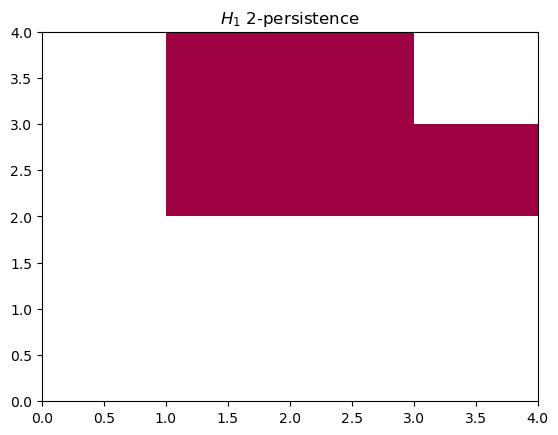

In [9]:
bimodule_approximation.plot(degree=1);

The red shape represent the lifetime of the circle that we defined. We see here that this cicle lives once all of the edges appeared in the filtration, i.e., after $(1,2)$ and dies once the triangle appears, i.e. after $(3,3)$. This makes this $L$ shaped summand.

The `image` function takes the following parameters :
- `dimension=-1` The homology dimension to plot (by default all dimension are showed)
- `resolution =[100,100]` the resolution of the image.
- `bandwidth=1` The bandwidth smoothing parameter.
- `plot=True` If true, plots the image.
- `p=0` If positive, will increase the weight of the larger summands.
- `box` Can be used to "zoom" into the original box.
- several matplotlib flags.

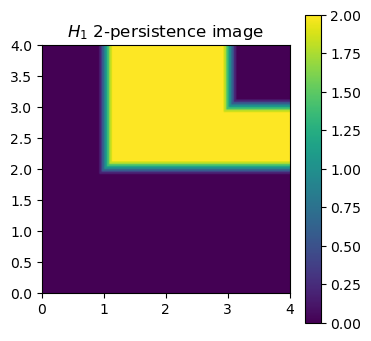

In [10]:
bimodule_approximation.image(degree=1, bandwidth=0.1, cb=1);

**Remark:** Multiparameter persistence landscapes can also be computed from modules, using the `landscape` and `landscapes` functions.

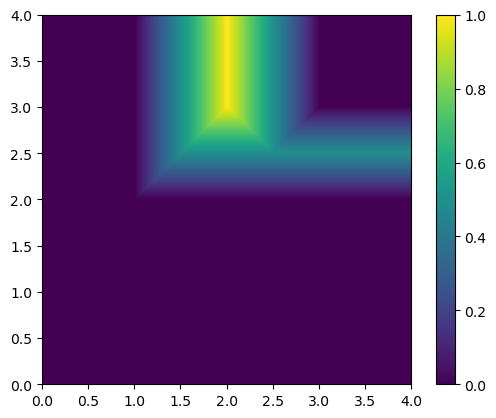

In [11]:
bimodule_approximation.landscape(degree=1, k=0, resolution=[500,500]); plt.colorbar();

**Remark:** 1-dimensional barcodes can also be efficiently sliced from a module, using the `barcode` and `barcodes` method. Note that when the approximation module is computed over a box that is too small, the barcodes outside the box are bot guaranteed to be exact.

/var/folders/qq/wykj3rzn6r7_07fh4q0j9frh0000gp/T/ipykernel_91414/3726223568.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bimodule_approximation.barcodes(num=100, degree=1, threshold=1).plot()


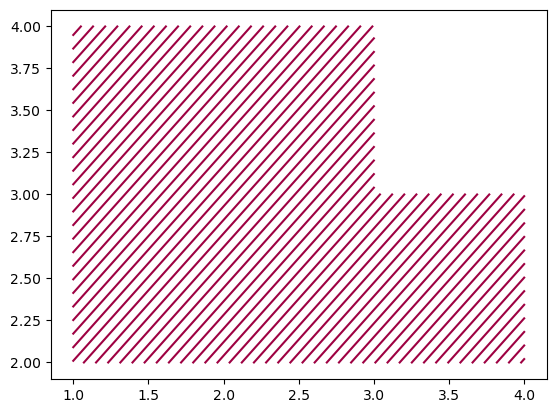

In [12]:
bimodule_approximation.barcodes(num=100, degree=1, threshold=1).plot()

For approximation examples, see the notebook `examples_of_approximations`

## Typical bi-filtration : Rips/Alpha + density

In [13]:
from mma import noisy_annulus
from sklearn.neighbors import KernelDensity

The noisy annulus dataset that we consider

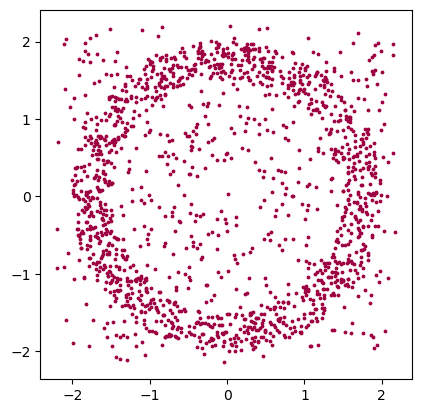

In [14]:
npts = 1000
noutliers = (int)(npts * 0.4)
np.random.seed(100)
X = np.block([[np.array(noisy_annulus(1.5,2, npts))], [np.random.uniform(low=-2, high=2, size=(noutliers,2))]] )
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(X[:,0], X[:,1],s=3)
plt.show()

In [15]:
 # Defines an alpha complex from the point cloud
ac = gd.AlphaComplex(points=X)
simplextree = ac.create_simplex_tree()

# For computational efficiency, alpha complexes can change the order of the points, we reorder them using
X = np.array([ac.get_point(i) for i in  range(simplextree.num_vertices())])

We convert a gudhi simplextree to an mma simplextree using the following command.

In [16]:
simplextree = mma.SimplexTreeMulti(simplextree, num_parameters=2)

The first filtration is the one from the original simplextree, we just have to fill the other one, with the codensity

In [17]:
 # Estimates the density of the point cloud
kde = KernelDensity(kernel='gaussian', bandwidth=1/4).fit(X)
codensity = -np.array(kde.score_samples(X))
for s,(f1,f2) in simplextree.get_simplices():
	simplextree.assign_filtration(s, (f1, np.max(codensity[s])))

Note that the for loop is equivalent to calling the macro `fill_lowerstar` that fills the lowerstar filtration given by the density.

In [18]:
simplextree.fill_lowerstar(codensity, parameter=1) # parameter = 1 is the second parameter, python starts from 0 :(

And we compute the persistence :)

In [20]:
 # The box on which to compute (alpha complexes can have very high filtration values)
box = [[0,1.5], [0.4,5]]

# Computes an approximation of the module
bimodule = simplextree.persistence_approximation(box=box)

Little plot !

/Users/dloiseau/micromamba/envs/python/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


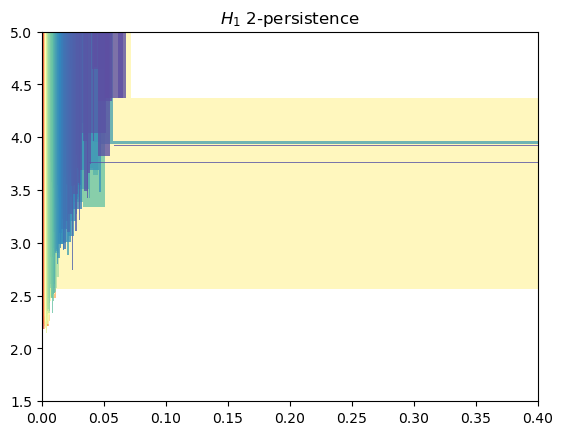

In [21]:
bimodule.plot(alpha=0.8, degree=1);

The annulus clearly appears :)

The $x$ axis is the alpha complex filtration, and the $y$ axis is the co-log-density (a simplex will appear earlier if it has a bigger density value) 

We can see in that example that there is only 1 significant (green) summand of dimension 1 representing the circle.

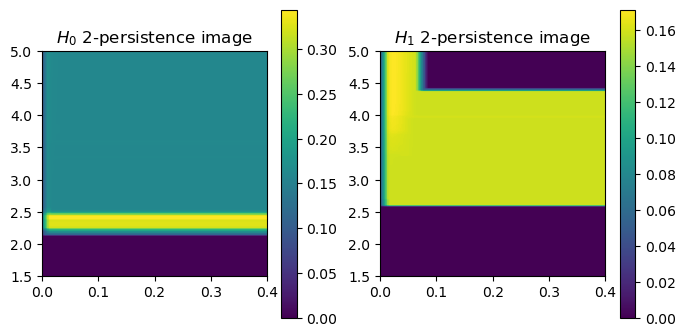

In [22]:
bimodule.image(bandwidth=0.01, p=2, colorbar=1);

## Rips filtrations

While multiparameter persitence filtrations induced by Rips complexes gives a more accurate topological complex in the multiparameter setting, they have in general **much** more simplices. It is thus necessary to use tricks to lower the number of simplicies without lowering too much the precision.

### Sparse Rips

[Sparse Rips](https://gudhi.inria.fr/python/latest/rips_complex_user.html) provide very close Rips complex filtrations (thus not exact), but will drastically lower the number of simplices (see [here](https://gudhi.inria.fr/python/latest/zbibliography.html#id83)) 

In [23]:
simplextree = gd.RipsComplex(points = X, sparse=0.3).create_simplex_tree(max_dimension=2) # try to keep the sparse parameter close to 0.

In [24]:
simplextree.num_simplices() # The number of simplices is still very high !

1308378

As before, we construct the mma simplextree, and fill the codensity filtration

In [25]:
simplextree = mma.SimplexTreeMulti(simplextree, num_parameters=2)
kde = KernelDensity(kernel='gaussian', bandwidth=1/4).fit(X)
codensity = -np.array(kde.score_samples(X))
simplextree.fill_lowerstar(codensity, parameter=1) # As before, this fills the second filtration by the codensity

Before computing the persistence, we will do another trick to reduce the number of simplices  :)

### Multiparameter persistence strong collapse (2-filtrations only)

In general, in a clique complex, a lot of cycle have a 0-length life. Strong collapses removes simplices that doesn't change the homology of the bifiltration. We use the Rust library [filtration_domination](https://github.com/aj-alonso/filtration_domination) to achieve this; with the `collapse_edges` method.

In [28]:
simplextree.collapse_edges(num=100, progress=1, ignore_warning=True) # can be done multiple times (num parameter), but will not improve a lot after a few runs.
simplextree.collapse_edges(num=100, strong=False, progress=1, ignore_warning=True) # non-strong collapse can remove more simplices but are slower.
# An equivalent of these two previous lines is using 
simplextree.collapse_edges(full=True, ignore_warning=True)
simplextree.num_simplices()

Removing edges:   0%|          | 0/100 [00:00<?, ?it/s]


13967

Yay ! This is computable now ! Lets compute it :)

In [29]:
bimodule = simplextree.persistence_approximation()

/Users/dloiseau/micromamba/envs/python/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


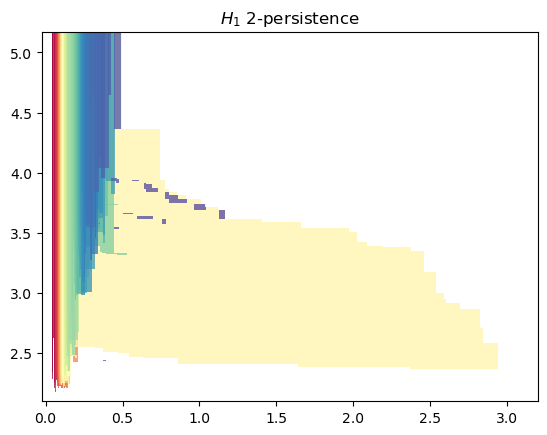

In [30]:
bimodule.plot(1, alpha = 0.8)

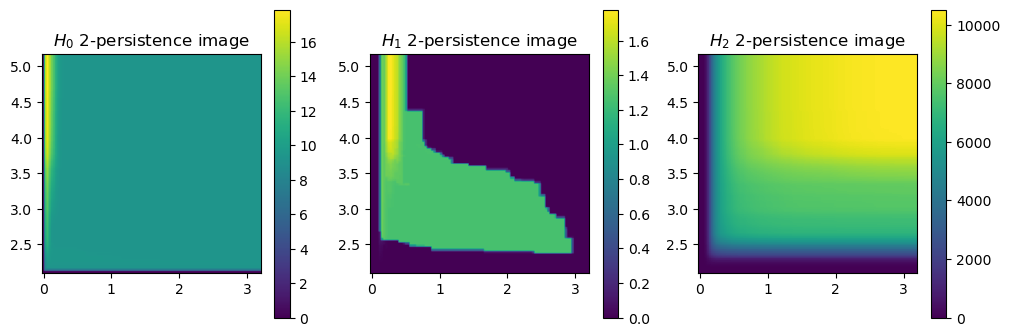

In [31]:
bimodule.image(bandwidth=0.01, p=2, colorbar=1);

## Matching distance error

Matching distance can be estimated by the `estimate_error` function. It computes barcodes from the module, and barcodes from gudhi and returns the maximum of the bottleneck distance error.

In [36]:
mma.estimate_error(simplextree, simplextree.persistence_approximation(max_error=0.001), degree=1, nlines=200, verbose=1)

Computing mma barcodes...Done. 0.09617900000012014s.


Computing bottleneck distances:  50%|█████     | 100/200 [00:00<00:00, 144.92it/s]


2.384185791015625e-07

In [37]:
mma.estimate_error(simplextree, simplextree.persistence_approximation(max_error=1), degree=1, nlines=200, verbose=1)

Computing mma barcodes...Done. 0.05904970799929288s.


Computing bottleneck distances:  50%|█████     | 100/200 [00:00<00:00, 277.50it/s]


0.5256457328796386

Note that error may be (slightly) higher than the `max_error` parameter (especially with more parameters, which are not well implemented yet).

# Euler surfaces

Euler characteristic of a module at a given point can also be computed from the module, or even from the simplextree, without having to compute the module. 
<br>
Note that computing it from an approximated module is faster but may not be exact.

In [38]:
x = np.linspace(0,3, num=100)
y = np.linspace(2,5, num=100)
x,y= np.meshgrid(x,y)
points = [[c,d] for a,b in zip(x,y) for c,d in zip(a,b)]
euler_curve = bimodule.euler_char(points)
euler_curve = simplextree.euler_char(points)

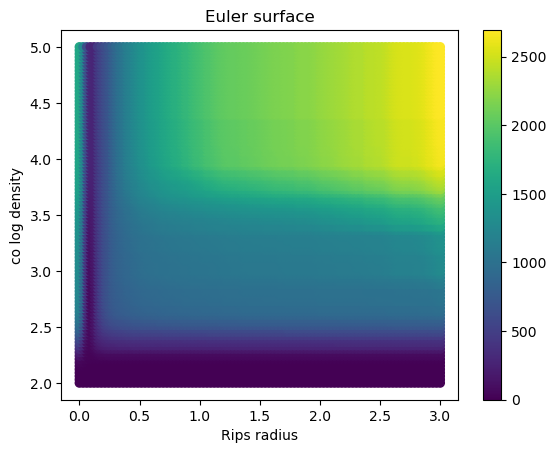

In [39]:
plt.scatter(x,y,c=euler_curve)
plt.xlabel("Rips radius")
plt.ylabel("co log density")
plt.title("Euler surface")
plt.colorbar();

## Export to rivet

mma simplextrees can be exported to a file that can be used by rivet afterwards. <br>
Warning, multicritical simplextrees are not implemented yet.

In [40]:
simplextree.to_rivet(path="rivet_dataset.txt", degree=1, overwrite=1)

They can also be exported to the firep format, for example to use mpfree/rivet.

In [42]:
simplextree.to_scc(path="firep.txt", overwrite=1)

In [43]:
!mpfree firep.txt firep_min

zsh:1: command not found: mpfree


## Higher number of parameters

The same syntax applies in higher persistence dimension : 

In [45]:
num_parameters = 3
# We take a random filtration of the form (lower-star for convenience)
simplextree.set_num_parameter(num_parameters)
for parameter in range(num_parameters):
    simplextree.fill_lowerstar(np.random.uniform(low = 0, high = 1, size=simplextree.num_vertices()), parameter=parameter)
box = simplextree.filtration_bounds()

In [48]:
%time n_mod_approximation = simplextree.persistence_approximation();

CPU times: user 30.8 s, sys: 128 ms, total: 31 s
Wall time: 31 s


But this code is still highly experimental, and there are no plotting functions with more than 2 parameters.